In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ====================
# Some preperation
# ====================

print("Preparing the data...")
df = pd.read_csv("final_df.csv")
df = df.sort_values(by=["gw", "player_id"], ascending=True)

# Drop the id columns until i find a better way to handle them
df = df.drop(columns=["player_id", "team_id", "opponent_team_id"])

# convert bool columns to int
df = df.apply(lambda x: x.astype(int) if x.dtype == "bool" else x)

# Split the data into 70% train, 15% validation, and 15% test sets
n_gws = int(df.gw.nunique())
train_end = int(n_gws * 0.7)
val_end = int(n_gws * 0.85)

train_df = df[df.gw <= train_end]
val_df = df[(df.gw > train_end) & (df.gw <= val_end)]
test_df = df[df.gw > val_end]

print(
    f"Train shape: {train_df.shape}, Val shape: {val_df.shape}, Test shape: {test_df.shape}"
)

# Separate features and target
X_train = train_df.drop(columns=["total_points"])
y_train = train_df["total_points"]
X_val = val_df.drop(columns=["total_points"])
y_val = val_df["total_points"]
X_test = test_df.drop(columns=["total_points"])
y_test = test_df["total_points"]

# Standardize the data
print("Standardizing the data...")
scaler = StandardScaler()

cols_to_scale = [col for col in X_train.columns if col != "gw"]

# Fit the scaler on the training data features (excluding 'gw')
scaler.fit(X_train[cols_to_scale])

# Transform the features for train, validation, and test sets
X_train_scaled = scaler.transform(X_train[cols_to_scale])
X_val_scaled = scaler.transform(X_val[cols_to_scale])
X_test_scaled = scaler.transform(X_test[cols_to_scale])

# Convert scaled arrays back to DataFrames
X_train_scaled_df = pd.DataFrame(
    X_train_scaled, columns=cols_to_scale, index=X_train.index
)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=cols_to_scale, index=X_val.index)
X_test_scaled_df = pd.DataFrame(
    X_test_scaled, columns=cols_to_scale, index=X_test.index
)

# Combine scaled features with the unscaled 'gw' column
X_train_processed = pd.concat([X_train[["gw"]], X_train_scaled_df], axis=1)
X_val_processed = pd.concat([X_val[["gw"]], X_val_scaled_df], axis=1)
X_test_processed = pd.concat([X_test[["gw"]], X_test_scaled_df], axis=1)

print(f"X_train_processed shape: {X_train_processed.shape}")
print(f"X_val_processed shape: {X_val_processed.shape}")
print(f"X_test_processed shape: {X_test_processed.shape}")

# ================================
# Neural Network Model Definition
# ================================

LEARNING_RATE = 0.0005
EPOCHS = 100
BATCH_SIZE = 64
DROPOUT_RATE = 0.2

# Define the model
model = keras.models.Sequential(
    [
        Input(shape=(X_train_processed.shape[1],)),
        BatchNormalization(),
        Dropout(DROPOUT_RATE),

        Dense(64, activation="relu"),
        BatchNormalization(),
        Dropout(DROPOUT_RATE),
        
        Dense(16, activation="relu"),
        Dense(1, activation="linear"),
    ]
)



# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="mean_squared_error",  # Common for regression
    metrics=["mean_absolute_error"],  # Optional: another metric to track
)

# Print model summary
model.summary()

# Train the model
# Optional: Early stopping to prevent overfitting
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", monitor="val_loss", save_best_only=True
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=6, min_lr=1e-6
    ),
]

history = model.fit(
    X_train_processed,
    y_train,
    epochs=100,
    validation_data=(X_val_processed, y_val),
    batch_size=64,
    callbacks=callbacks,
    verbose=1,
)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test_processed, y_test, verbose=0)
print(f"\nTest MAE: {test_mae:.4f}")
print(f"Test Loss (MSE): {test_loss:.4f}")


# To make predictions:
# predictions = model.predict(X_test_processed)

Preparing the data...
Train shape: (14598, 200), Val shape: (3565, 200), Test shape: (5170, 200)
Standardizing the data...
X_train_processed shape: (14598, 199)
X_val_processed shape: (3565, 199)
X_test_processed shape: (5170, 199)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_7           │ (None, 199)            │           796 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 199)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,909 (58.24 KB)

 Trainable params: 14,383 (56.18 KB)

 Non-trainable params: 526 (2.05 KB)

Epoch 1/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 6.9512 - mean_absolute_error: 1.5992 - val_loss: 3.8814 - val_mean_absolute_error: 1.1300 - learning_rate: 5.0000e-04
Epoch 2/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.2813 - mean_absolute_error: 1.2065 - val_loss: 3.7291 - val_mean_absolute_error: 1.1240 - learning_rate: 5.0000e-04
Epoch 3/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.1134 - mean_absolute_error: 1.1665 - val_loss: 3.7114 - val_mean_absolute_error: 1.1137 - learning_rate: 5.0000e-04
Epoch 4/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.0216 - mean_absolute_error: 1.1453 - val_loss: 3.6369 - val_mean_absolute_error: 1.0877 - learning_rate: 5.0000e-04
Epoch 5/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.9586 - mean_absolute_error: 1.1266 - val_loss: 3.6006 - val_mean_absolute_error: 1.0686 - learning_rate: 5.0000e-04
Epoch 6/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.9665 - mean_absolute_error: 1.1131 - val_l

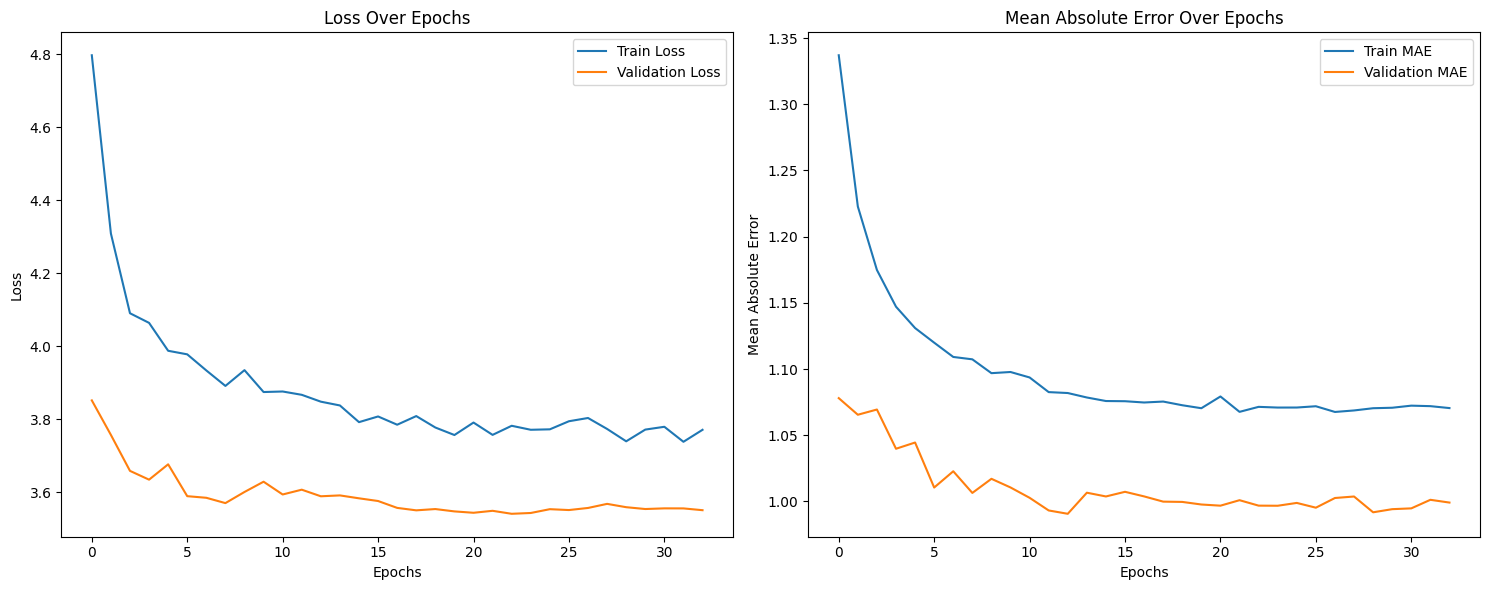

In [2]:
# Plots
plt.figure(figsize=(15, 6))  # Adjusted figure size for two subplots

# First subplot: Loss Over Epochs
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Second subplot: Mean Absolute Error Over Epochs
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(history.history["mean_absolute_error"], label="Train MAE")
plt.plot(history.history["val_mean_absolute_error"], label="Validation MAE")
plt.title("Mean Absolute Error Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()

plt.tight_layout()  # Adjusts subplot params for a tight layout
plt.show()


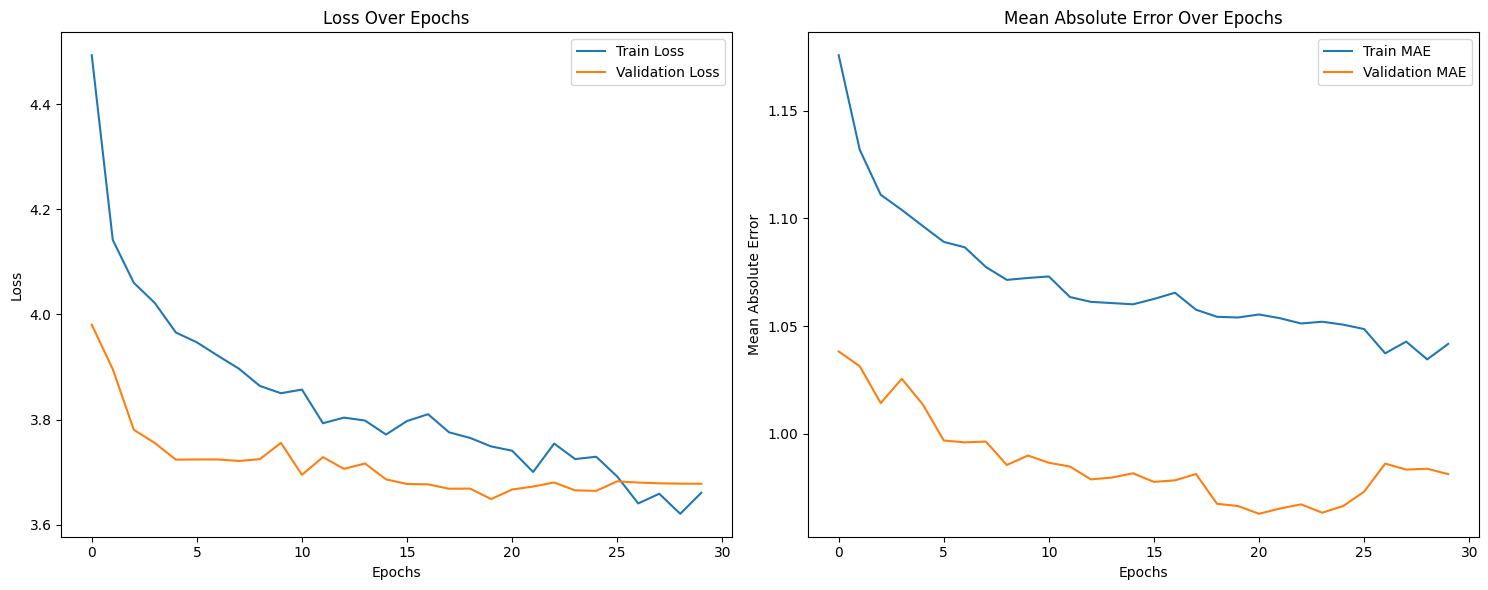

In [5]:
# Plots
plt.figure(figsize=(15, 6))  # Adjusted figure size for two subplots

# First subplot: Loss Over Epochs
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Second subplot: Mean Absolute Error Over Epochs
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(history.history["mean_absolute_error"], label="Train MAE")
plt.plot(history.history["val_mean_absolute_error"], label="Validation MAE")
plt.title("Mean Absolute Error Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()

plt.tight_layout()  # Adjusts subplot params for a tight layout
plt.show()


In [3]:
model.evaluate(X_test_processed, y_test, verbose=1)

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.6981 - mean_absolute_error: 1.1883
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.6981 - mean_absolute_error: 1.1883


[3.946948289871216, 1.0561410188674927]

In [ ]:
predictions = model.predict(X_test_processed)



162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
